In [4]:
%pip install datasets
from datasets import load_dataset




In [2]:
from datasets import load_dataset


# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("hendzh/PromptShield")

README.md:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

train.json:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

validation.json:   0%|          | 0.00/646k [00:00<?, ?B/s]

test.json:   0%|          | 0.00/18.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18909 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/23516 [00:00<?, ? examples/s]

In [17]:
%pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [3]:
%pip install protobuf
%pip install sentencepiece
from transformers import AutoTokenizer


model_name = "microsoft/deberta-v3-small"

tokenizer = AutoTokenizer.from_pretrained(model_name)
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "microsoft/deberta-v3-small"
MAX_LEN = 384
BATCH_SIZE = 8
EPOCHS = 3
LR = 0.00001

In [13]:
# Load from Hugging Face
dataset = load_dataset("hendzh/PromptShield")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(example):
    return tokenizer(example["prompt"], padding="max_length", truncation=True, max_length=MAX_LEN)

tokenized = dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/18909 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/23516 [00:00<?, ? examples/s]

In [14]:
class PromptShieldDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"]),
            "attention_mask": torch.tensor(item["attention_mask"]),
            "label": torch.tensor(item["label"])
        }

train_dataset = PromptShieldDataset(tokenized["train"])
val_dataset = PromptShieldDataset(tokenized["validation"])
test_dataset = PromptShieldDataset(tokenized["test"])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [15]:
device

device(type='cuda')

In [16]:
!pip install torchtoolbox
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

from torchtoolbox.nn import FocalLoss
from transformers import get_scheduler

# Freeze embedding and first encoder layer for stability
for name, param in model.named_parameters():
    if "embeddings" in name or "encoder.layer.0" in name:
        param.requires_grad = False

# Send model to device
model.to(device)

class_weights = torch.tensor([2.0, 1.0]).to(device)
loss_fn = FocalLoss(classes=2, gamma=2.0, weight=class_weights)

# Optimizer and LR scheduler
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * EPOCHS,
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Avg training loss = {avg_loss:.4f}")

Epoch 1: 100%|██████████| 2364/2364 [14:24<00:00,  2.73it/s]


Epoch 1: Avg training loss = 0.0259


Epoch 2: 100%|██████████| 2364/2364 [14:22<00:00,  2.74it/s]


Epoch 2: Avg training loss = 0.0012


Epoch 3: 100%|██████████| 2364/2364 [14:23<00:00,  2.74it/s]

Epoch 3: Avg training loss = 0.0005


In [18]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
%pip install matplotlib -y
import matplotlib.pyplot as plt
import numpy as np


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [19]:
def full_evaluation(model, dataloader, name="Set"):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs[:, 1].cpu().numpy())   # P(injected)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Accuracy, F1, classification report
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Benign", "Injected"])

    # TPR (Recall) & FPR
    tp = np.sum((all_preds == 1) & (all_labels == 1))
    fn = np.sum((all_preds == 0) & (all_labels == 1))
    fp = np.sum((all_preds == 1) & (all_labels == 0))
    tn = np.sum((all_preds == 0) & (all_labels == 0))
    tpr = tp / (tp + fn + 1e-6)
    fpr = fp / (fp + tn + 1e-6)

    # ROC AUC
    auc = roc_auc_score(all_labels, all_probs)

    # Print metrics
    print(f"📊 Results on {name}")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, ROC AUC: {auc:.4f}")
    print(f"TPR (Recall): {tpr:.4f}, FPR: {fpr:.4f}")
    print(report)

    # Plot ROC curve
    fpr_curve, tpr_curve, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr_curve, tpr_curve, label=f"AUC = {auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({name})")
    plt.legend()
    plt.grid()
    plt.show()


🔍 Validation Set:
📊 Results on Validation
Accuracy: 0.9990, F1 Score: 0.9990, ROC AUC: 1.0000
TPR (Recall): 1.0000, FPR: 0.0020
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       497
    Injected       1.00      1.00      1.00       503

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



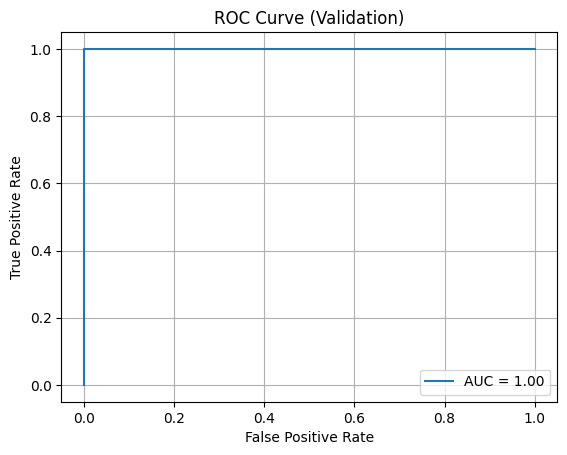

🔍 Test Set:
📊 Results on Test
Accuracy: 0.9483, F1 Score: 0.9055, ROC AUC: 0.9625
TPR (Recall): 0.8972, FPR: 0.0322
              precision    recall  f1-score   support

      Benign       0.96      0.97      0.96     17030
    Injected       0.91      0.90      0.91      6486

    accuracy                           0.95     23516
   macro avg       0.94      0.93      0.93     23516
weighted avg       0.95      0.95      0.95     23516



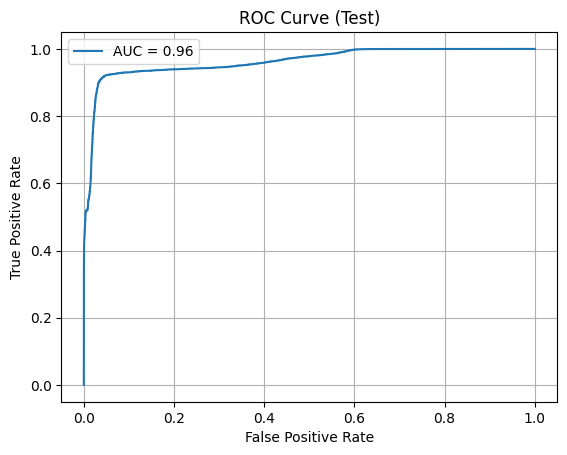

In [20]:
print("🔍 Validation Set:")
full_evaluation(model, val_loader, name="Validation")

print("🔍 Test Set:")
full_evaluation(model, DataLoader(test_dataset, batch_size=BATCH_SIZE), name="Test")

In [21]:
model.save_pretrained("./deberta-promptshield")
tokenizer.save_pretrained("./deberta-promptshield")

('./deberta-promptshield/tokenizer_config.json',
 './deberta-promptshield/special_tokens_map.json',
 './deberta-promptshield/spm.model',
 './deberta-promptshield/added_tokens.json',
 './deberta-promptshield/tokenizer.json')

In [23]:
!git config --global user.name "Zrahay"
!git config --global user.email "shubhangsinha44@gmail.com"
!git init
!git add .
!git commit -m "Initial commit"
!git push -u origin main


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
^C
On branch master

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	deberta-promptshield/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'origin'
